In [1]:
# 0: fpe, 1: vsw, 2: te
select_parameter = 1
parameter = ["fpe", "vsw", "te"][select_parameter]

continue_after_training = True
continue_after_testing = False

## Import Statements

In [2]:
import gc
import os
import sys
import random
import pickle
import bisect
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.environ["CDF_LIB"] = "/usr/local/lib/cdf/lib/"
import netCDF4 as nc
import pyspedas
from spacepy import pycdf
from pyspedas import wind
from pytplot import tplot, get_data

## Various functions

In [3]:
# Constants
e = 1.602176634e-19
m = 9.109383701528e-31
e_0 = 8.854187812813e-12
cons = e/((m*e_0)**.5)/(2*np.pi)
print(e**2/(e_0*m))
print(cons)

3182.6073539848016
8.978662820467044


In [4]:
def find_closest_time(time, lst):
    return min(range(len(lst)), 
               key=lambda i: abs(time-lst[i]))

def reduced_time_closest_time(goal_time, time_lst):
    """
    Find the index in the availible times which is closest to the goal time
    """
    # Bisect gives the index of the smallest value which is greater than goal time
    upper_index = min(bisect.bisect_left(time_lst, goal_time), len(time_lst)-1)
    lower_index = max(upper_index-1, 0)
    if abs(time_lst[upper_index] - goal_time) > abs(time_lst[lower_index] - goal_time):
        return lower_index
    else:
        return upper_index

def conv_dens_to_freq(ne):
    assert ne>=0
    return ne**.5 * cons

def norm(lst, max_val):
    return np.array([val/max_val for val in lst])

def denorm(lst, max_val):
    return np.array([val*max_val for val in lst])

def print_lst(lst, sort=False):
    if sort:
        lst.sort()
    print("[")
    for n in lst:
        print(f"{repr(n)},")
    print("]")

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)


## Importing Data

### pySPEDAS

In [5]:
wind.swe(trange=['1995-06-01', '1995-06-27'], datatype='h0', no_update=True)
wind.swe(trange=['1995-06-01', '1995-06-27'], datatype='k0', no_update=True)
wind.threedp(trange=['1995-06-01', '1995-06-27'], datatype="3dp_elm2")


19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: Searching for local files...
19-Aug-22 16:20:21: 

[]

In [6]:
pyspedas_data = get_data('Te')
time_te, te = list(zip(*[data for data in filter(lambda lst: lst[1]<3e5 and lst[1]>0,zip(pyspedas_data.times,pyspedas_data.y))]))

# tplot('V_GSM')

In [7]:
vsw_folder = "wind_data/3dp/3dp_elm2/1995/"

vsw_data = [ vsw_folder+file for file in os.listdir(vsw_folder) if file.endswith(".cdf")]
vsw_data.sort()

(20121,)


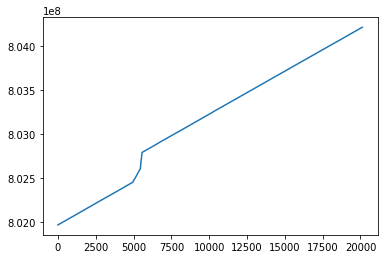

In [8]:
time_vsw, vsw_xyz = [],[]
for vsw_file_name in vsw_data:
    with pycdf.CDF(vsw_file_name) as cdf:
        temp_vsw = cdf["VEL_MAG"][:]
        temp_time = cdf["TIME"][:]
        
    if not temp_time[0] in time_vsw:
        vsw_xyz.extend(temp_vsw)
        time_vsw.extend(np.transpose(temp_time))

print(np.shape(vsw_xyz))
plt.plot(time_vsw)

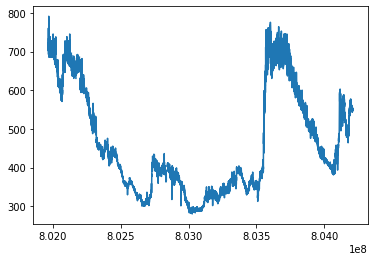

In [9]:
f = lambda x, y, z: np.sqrt(np.add(np.power(x,2),np.power(y,2), np.power(z,2)))
plt.plot(time_vsw, f(*np.transpose(vsw_xyz)))

In [29]:
time_vsw, vsw_xyz = list(zip(*[data for data in filter(lambda lst: not any([np.isnan(lst[1][0]),np.isnan(lst[1][1]), np.isnan(lst[1][2])]),zip(time_vsw,vsw_xyz))]))
vsw = f(*np.transpose(vsw_xyz))

IndexError: invalid index to scalar variable.

In [9]:
time_vsw, vsw_xyz = list(zip(*[data for data in filter(lambda lst: not np.isnan(lst[1]),zip(time_vsw,vsw_xyz))]))


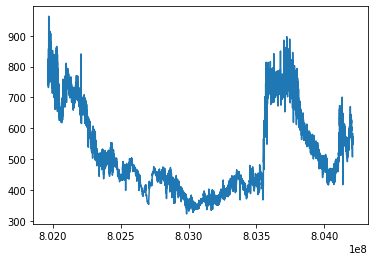

In [12]:
plt.plot(time_vsw, vsw_xyz)

### Solaris and CDPP data

In [5]:
spectra_folder = "data/solaris/1995-06/"
nn_folder = "data/cdpp/34069/DA_TC_WIND_WAVES_TNR_L3_NN/"

spectra_data = [ spectra_folder+file for file in os.listdir(spectra_folder) if file.endswith(".nc")]
nn_data = [ nn_folder+file for file in os.listdir(nn_folder) if file.endswith(".nc")]
spectra_data.sort()
nn_data.sort()
combined_data = zip(spectra_data, nn_data)
#print_lst(combined_data)

In [6]:
time_spec = []
freq = []
raw_spec = []
time_fpe = []
fpe = []
electron_density = []
for spectra_file_name, nn_file_name in combined_data:
    date = spectra_file_name[32:-3]
    date_epoch = int(datetime.datetime(int(date[0:4]), int(date[4:6]), int(date[6:8]), 0, 0, 0, 
                                       tzinfo=datetime.timezone.utc).timestamp())
    
    with nc.Dataset(spectra_file_name) as file:
        temp_time = file["tnr_ch1_time"][:]
        temp_spec = file["tnr_ch1_spec"][:]
        if len(freq) == 0:
            freq  = file["tnr_ch1_freq"][:]
    
    with nc.Dataset(nn_file_name) as file:
        temp_time2   = file["Time"][:]
        temp_raw_fpe = file["Plasma Frequency"][:]
        temp_dens    = file["Electron Density"][:]
        
        # Found slight bug where the times over some days are shifted by 86400 seconds up
        if temp_time2[10] >= 86400:
            print(f"Corrected: {spectra_file_name}")
            temp_time2 = np.subtract(temp_time2, 86400)
        temp_time2 = np.add(temp_time2, date_epoch)

    if not temp_time[0] in time_spec:
        time_spec.extend(temp_time)
        raw_spec.extend(np.transpose(temp_spec))
        time_fpe.extend(temp_time2)
        fpe.extend(temp_raw_fpe)
        electron_density.extend(temp_dens)
        
    else:
        print(spectra_file_name)
print(len(time_spec))
print(np.shape(raw_spec))

Correced: data/solaris/1995-06/wi_wav_tnr_19950603.nc
Correced: data/solaris/1995-06/wi_wav_tnr_19950604.nc
Correced: data/solaris/1995-06/wi_wav_tnr_19950611.nc
Correced: data/solaris/1995-06/wi_wav_tnr_19950618.nc
Correced: data/solaris/1995-06/wi_wav_tnr_19950619.nc
505726
(505726, 96)


In [9]:
pd.DataFrame([time_spec[i+1]-time_spec[i] for i in range(len(time_spec)-1)]).describe()

,0
count,505725.000000
mean,4.441825
std,3.465778
min,-30.592000
25%,4.416000
50%,4.416000
75%,4.416000
max,1594.176000


In [14]:
if parameter=="fpe":
    time_fpe, fpe, electron_density = list(zip(*[d for d in zip(time_fpe, fpe, electron_density) if d[1]>1]))
    spec = [raw_spec[reduced_time_closest_time(t, time_spec)] for t in time_fpe]

elif parameter=='vsw':
    spec = [raw_spec[reduced_time_closest_time(t, time_spec)] for t in time_vsw]
    
elif parameter=='te':
    spec = [raw_spec[reduced_time_closest_time(t, time_spec)] for t in time_te]


In [15]:
print(np.shape(time_spec), np.shape(spec), np.shape(fpe), np.shape(electron_density), np.shape(te))
if parameter=="fpe":
    data_v1 = list(zip(time_fpe, spec, fpe, electron_density))
elif parameter=='vsw':
    data_v1 = list(zip(time_vsw, spec, vsw))
elif parameter=='te':
    data_v1 = list(zip(time_te, spec, te))

(505726,) (21109, 96) (505528,) (505528,) (6479,)


In [16]:
len(vsw)

21109

## Randomizing and sorting data

In [17]:
random.seed(10)
random_index = list(range(len(data_v1)))
random.shuffle(random_index)
data_v3 = [data_v1[i] for i in random_index]    

In [18]:
max_y = 50 
s = int(len(data_v3)*.9//1)
print(np.shape(data_v3[:s]))


# Takes the training section of the data and unzips the test and training data
train_x_data         = np.array([d[1] for d in data_v3[:s]])
if parameter=="fpe":
    train_y_data     = np.array([d[2]/max_y for d in data_v3[:s]])
    train_y_data_ed  = np.array([d[3] for d in data_v3[:s]])
if parameter=="te":
    train_y_data_te  =  np.array([d[2] for d in data_v3[:s]])
if parameter=="vsw":
    train_y_data_vsw =  np.array([d[2] for d in data_v3[:s]])
print("Done with creating trainning data")

# Sorts test data so we could use that sorted data to make nice graphs at the end
test_sorted = data_v3[s:]
test_sorted.sort(key=lambda x: x[0])
print("Done sorting")

test_time_sorted = np.array([d[0] for d in test_sorted])
test_x_sorted    = np.array([d[1] for d in test_sorted])
if parameter=="fpe":
    test_y_sorted    = np.array([d[2]/max_y for d in test_sorted])
    test_y_sorted_ed = np.array([d[3] for d in test_sorted])
if parameter=="te":
    test_y_sorted_te =  np.array([d[2] for d in test_sorted])
if parameter=="vsw":
    test_y_sorted_vsw =  np.array([d[2] for d in test_sorted])

print("Done with creating test data")

19-Aug-22 13:25:36: /home/ayushmaan/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape



(18998, 3)
Done with creating trainning data
Done sorting
Done with creating test data


In [19]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                  train_x_data: 13.9 MiB
                     time_spec:  4.3 MiB
                      raw_spec:  4.3 MiB
                      time_fpe:  4.3 MiB
                           fpe:  4.3 MiB
              electron_density:  4.3 MiB
                 test_x_sorted:  1.5 MiB
                          spec: 169.0 KiB
                       data_v1: 169.0 KiB
                       data_v3: 169.0 KiB


In [20]:
data_dic = {}
data_dic["freq"]             = freq
data_dic["max_y"]            = max_y
data_dic["train_x_data"]     = train_x_data
if parameter=="fpe":
    data_dic["train_y_data"]     = train_y_data
    data_dic["train_y_data_ed"]  = train_y_data_ed
if parameter=="te":
    data_dic["train_y_data_te"]  = train_y_data_te
if parameter=="vsw":
    data_dic["train_y_data_vsw"]  = train_y_data_vsw
data_dic["test_time_sorted"] = test_time_sorted
data_dic["test_x_sorted"]    = test_x_sorted
if parameter=="fpe":
    data_dic["test_y_sorted"]    = test_y_sorted
    data_dic["test_y_sorted_ed"] = test_y_sorted_ed
if parameter=="te":
    data_dic["test_y_sorted_te"] = test_y_sorted_te
if parameter=="vsw":
    data_dic["test_y_sorted_vsw"] = test_y_sorted_vsw

In [21]:
with open(f"data/pickle/data_{parameter}", 'wb') as file:
    pickle.dump(data_dic, file=file)